In [ ]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

# 1. Imports

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import numpy as np
import pandas as pd

import rioxarray as rxr
import geopandas as gpd

import pylandstats as pls
from src.demo.plot_settings import ps_defaults, label_subplots, set_dim


ps_defaults(use_tex=True)
import tqdm

from src.geograph import GeoGraph
from src.geotimeline import GeoGraphTimeline
from src.constants import DATA_DIR, UTM35N, ROIS

In [ ]:
plot_scale_factor = 1.8  # To scale plot sizes for report 

# 2. Loading Chernobyl Landcover data (ESA CCI)

For this demonstration we will use the ESA CCI landcover dataset as an example to illustrate how
geographs enable us to reproduce the same metrics that traditional fragmentation software (pylandstats, fragstats)
produce.

In this demo we will look specifically at the Chernobyl exclusion zone, so we reproject the satellite data to the right coordinate
system (UTM35N) and clip to the CEZ region of interest).

In [ ]:
# Parse geotif landcover data
chernobyl_path = lambda year: DATA_DIR / "chernobyl" / "esa_cci" / f"esa_cci_{year}_chernobyl.tif" 

# Parse ROIS
rois = gpd.read_file(ROIS)
cez = rois[rois["name"] == "Chernobyl Exclusion Zone"]
pez = rois[rois["name"] == "Polesie Exclusion Zone"]
e30 = rois[rois["name"] == "E+30"]
e60 = rois[rois["name"] == "E+60"]

For convenience, let us also define certain groups of land cover classes from the ESA CCI data (c.f. Appendix of this notebook for a full list of classes)

In [ ]:
cropland = [10, 20]
deciduous_forest = [60, 61, 62, 80, 81, 82]
evergreen_forest = [70, 71, 72]
wetlands = [160, 170, 180]
urban = [190]
water = [210]

Next, let us load the raster data into memory, clip to the regions of interest and reproject to UTM35N

In [ ]:
def clip_and_reproject(xrdata, clip_geometry=None, to_crs=UTM35N, x_res=300, y_res=300):
    
    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata
        
    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data
    
    return reprojected_data

In [ ]:
# Loading raster data
years = range(2000, 2015)
zones = [cez, pez, e30, e60]


rasters = {zone.name.iloc[0]: {year: clip_and_reproject(rxr.open_rasterio(chernobyl_path(year)), 
                                    clip_geometry=zone.geometry) 
                               for year in years}
           for zone in zones}

## 2.1 Loading the Chernobyl Exclusion Zone (CEZ)

In [ ]:
# Demo path includes pre-loaded graphs for faster loading
demo_path = DATA_DIR / "chernobyl" / "graphs"

In [ ]:
# Loading geographs
#cez_graphs = {year: GeoGraph(demo_path / f"cez_graph_{year}.gz")
#              for year in years}

cez_graphs = {}
for year, raster in rasters["Chernobyl Exclusion Zone"].items():
    print(f"Analysing year {year}")
    cez_graphs[year] = GeoGraph(data=raster.data.squeeze(), 
                             transform=raster.rio.transform(), 
                             crs=UTM35N, 
                             connectivity=8)

for graph in cez_graphs.values():
    no_data_nodes = graph.df[graph.df["class_label"] == 0].index
    graph._remove_nodes(no_data_nodes)

In [ ]:
# Loading raster data into pylandstats
cez_landscapes = {year: pls.Landscape(rasters["Chernobyl Exclusion Zone"][year].data.squeeze(), 
                                  res=(300,300) , 
                                  nodata=0) 
                  for year in years}

## 2.2 Loading the Polesia Exclusion Zone (PEZ)

In [ ]:
# Loading geographs
#pez_graphs = {year: GeoGraph(demo_path / f"pez_graph_{year}.gz")
#              for year in years}

pez_graphs = {}
for year, raster in rasters["Polesie Exclusion Zone"].items():
    print(f"Analysing year {year}")
    pez_graphs[year] = GeoGraph(data=raster.data.squeeze(), 
                             transform=raster.rio.transform(), 
                             crs=UTM35N, 
                             connectivity=8)

for graph in pez_graphs.values():
    no_data_nodes = graph.df[graph.df["class_label"] == 0].index
    graph._remove_nodes(no_data_nodes)

In [ ]:
# Loading raster data into pylandstats
pez_landscapes = {year: pls.Landscape(rasters["Polesie Exclusion Zone"][year].data.squeeze(), 
                                  res=(300,300) , 
                                  nodata=0) 
                  for year in years}

## 2.3 Loading the 30 km surroundings

In [ ]:
# Loading geographs
#e30_graphs = {year: GeoGraph(demo_path / f"e30_graph_{year}.gz")
#              for year in years}

In [ ]:
# Loading raster data into pylandstats
e30_landscapes = {year: pls.Landscape(rasters["E+30"][year].data.squeeze(), 
                                  res=(300,300) , 
                                  nodata=0) 
                  for year in years}

## 2.3 Plot the data

Let's plot a sample region for the year 2000 for each of the regions to see that we correctly loaded the data

In [ ]:
cez_graphs[2000].df.plot("class_label")
plt.title("Chernobyl exclusion zone");

In [ ]:
pez_graphs[2000].df.plot("class_label")
plt.title("Polesia exclusion zone");

In [ ]:
#e30_graphs[2000].df.plot("class_label")
#plt.title("30km buffer around exclusion zones");

# 3. Metrics calculation

In [ ]:
# Drop no-data nodes:
for graph in cez_graphs.values():
    no_data_nodes = graph.df[graph.df["class_label"] == 0].index
    graph._remove_nodes(no_data_nodes)

for graph in pez_graphs.values():
    no_data_nodes = graph.df[graph.df["class_label"] == 0].index
    graph._remove_nodes(no_data_nodes)
    
#for graph in e30_graphs.values():
#    no_data_nodes = graph.df[graph.df["class_label"] == 0].index
#    graph._remove_nodes(no_data_nodes)

In [ ]:
cez_graph_timestack = GeoGraphTimeline(cez_graphs)
pez_graph_timestack = GeoGraphTimeline(pez_graphs)
#e30_graph_timestack = GeoGraphTimeline(e30_graphs)

In [ ]:
# Calculate pylandstats shannon diversity indices for entire landscapes
cez_pls_shannon = [cez_landscapes[year].shannon_diversity_index() for year in years]
pez_pls_shannon = [pez_landscapes[year].shannon_diversity_index() for year in years]
#e30_pls_shannon = [e30_landscapes[year].shannon_diversity_index() for year in years]

In [ ]:
# Calculate pylandstats effective mesh size for class 100 (mixed forest and shrub lands)
cez_pls_effm = [cez_landscapes[year].effective_mesh_size(100) for year in years]
pez_pls_effm = [pez_landscapes[year].effective_mesh_size(100) for year in years]
#e30_pls_effm = [e30_landscapes[year].effective_mesh_size(100) for year in years]

In [ ]:
# Calculate pylandstats mean fractal dimension for class 100 (mixed forest and shrub lands)
cez_pls_fracdim = [cez_landscapes[year].fractal_dimension_mn(100) for year in years]
pez_pls_fracdim = [pez_landscapes[year].fractal_dimension_mn(100) for year in years]
#e30_pls_fracdim = [e30_landscapes[year].fractal_dimension_mn(100) for year in years]

In [ ]:
# Calculate time-series patch metrics for geographs
cez_patch_metrics =  cez_graph_timestack.get_patch_metrics("mean")
pez_patch_metrics =  pez_graph_timestack.get_patch_metrics("mean")
#e30_patch_metrics =  e30_graph_timestack.get_patch_metrics("mean")

cez_patch_metrics_std =  cez_graph_timestack.get_patch_metrics("std")
pez_patch_metrics_std =  pez_graph_timestack.get_patch_metrics("std")
#e30_patch_metrics_std =  e30_graph_timestack.get_patch_metrics("std")

In [ ]:
# Warning - computation of all edges takes a long time (~tens of minutes)

#cez_graph_timestack.add_habitat("wetlands (1 km)", valid_classes=wetlands, max_travel_distance=1e3)
#cez_graph_timestack.habitats["wetlands (1 km)"].get_metric("avg_component_isolation")
#cez_graph_timestack.habitats["wetlands (1 km)"].get_metric("avg_component_isolation").to_netcdf("./cez_wetlands_1km.ncdf")

#cez_graph_timestack.add_habitat("wetlands (5 km)", valid_classes=wetlands, max_travel_distance=5e3)
#cez_graph_timestack.habitats["wetlands (5 km)"].get_metric("avg_component_isolation")
#cez_graph_timestack.habitats["wetlands (5 km)"].get_metric("avg_component_isolation").to_netcdf("./cez_wetlands_5km.ncdf")

#cez_graph_timestack.add_habitat("wetlands (10 km)", valid_classes=wetlands, max_travel_distance=10e3)
#cez_graph_timestack.habitats["wetlands (10 km)"].get_metric("avg_component_isolation")
#cez_graph_timestack.habitats["wetlands (10 km)"].get_metric("avg_component_isolation").to_netcdf("./cez_wetlands_10km.ncdf")

#cez_graph_timestack.add_habitat("wetlands (20 km)", valid_classes=wetlands, max_travel_distance=20e3)
#cez_graph_timestack.habitats["wetlands (20 km)"].get_metric("avg_component_isolation")
#cez_graph_timestack.habitats["wetlands (20 km)"].get_metric("avg_component_isolation").to_netcdf("./cez_wetlands_20km.ncdf")

In [ ]:
# Helper function with boilerplate code for plotting graph metrics
def plot_graph_metrics(ax, metric, 
                       class_value=None, 
                       plot_scale_factor=plot_scale_factor, 
                       marker="*", 
                       linewidth=1, 
                       conversion_factor=1,
                       markersize=3):
    
    ax.plot(cez_graph_timestack.times, 
            cez_graph_timestack.get_metric(metric, class_value) * conversion_factor, 
            linewidth = linewidth * plot_scale_factor,
            linestyle="dashed",
            color="C0",
            marker=marker,
            markersize=markersize * plot_scale_factor,
            )
    
    ax.plot(pez_graph_timestack.times, 
         pez_graph_timestack.get_metric(metric, class_value) * conversion_factor, 
         linewidth = linewidth * plot_scale_factor,
         linestyle="dashed",
         color="C1",
         marker=marker,
         markersize=markersize * plot_scale_factor,
         )
    
    #ax.plot(e30_graph_timestack.times, 
    #     e30_graph_timestack.get_metric(metric, class_value) * conversion_factor, 
    #     linewidth = linewidth * plot_scale_factor,
    #     linestyle="dashed",
    #     color="C2",
    #     marker=marker,
    #     markersize=markersize * plot_scale_factor,
    #     )

In [ ]:
# Helper function with boilerplate code for plotting pylandstats metrics
def plot_pls_metric(ax, 
                    metrics, 
                    plot_scale_factor=plot_scale_factor, 
                    marker="x", 
                    linewidth=1, 
                    markersize=4):
    
    cez_vals, pez_vals, e30_vals = metrics
    
    ax.plot(cez_graph_timestack.times, 
         cez_vals,
         linewidth = linewidth * plot_scale_factor,
         linestyle="dashed",
         color="C0",
         marker=marker,
         markersize=markersize * plot_scale_factor)

    ax.plot(pez_graph_timestack.times, 
         pez_vals,
         linewidth = linewidth * plot_scale_factor,
         linestyle="dashed",
         color="C1",
         marker=marker,
         markersize=markersize * plot_scale_factor)

    #ax.plot(e30_graph_timestack.times, 
    #     e30_vals,
    #     linewidth = linewidth * plot_scale_factor,
    #     linestyle="dashed",
    #     color="C2",
    #     marker=marker,
    #     markersize=markersize * plot_scale_factor,)

In [ ]:
import xarray as xr
#wetlands_0km_component_isolation = xr.open_dataset(DATA_DIR / "chernobyl"/ "wetlands" / "cez_wetlands.ncdf").to_array().squeeze()
wetlands_1km_component_isolation = xr.open_dataset(DATA_DIR / "chernobyl"/ "wetlands" / "cez_wetlands_1km.ncdf").to_array().squeeze()
wetlands_5km_component_isolation = xr.open_dataset(DATA_DIR / "chernobyl"/ "wetlands" / "cez_wetlands_5km.ncdf").to_array().squeeze()
wetlands_10km_component_isolation = xr.open_dataset(DATA_DIR / "chernobyl"/ "wetlands" / "cez_wetlands_10km.ncdf").to_array().squeeze()
wetlands_20km_component_isolation = xr.open_dataset(DATA_DIR / "chernobyl"/ "wetlands" / "cez_wetlands_20km.ncdf").to_array().squeeze()

In [ ]:
colors = sns.color_palette("rocket_r").as_hex()
colors

In [ ]:
#plt.subplots(2,2)
plot_scale_factor=1
fig, ax = plt.subplots(2, 2, sharex="col")
set_dim(fig, fraction_of_line_width=plot_scale_factor)
colors = sns.color_palette("rocket_r").as_hex()

# Top left plot
ax[0,0].set_title("Landscape:\nShannon Diversity Index", fontsize=8*plot_scale_factor)
plot_graph_metrics(ax[0,0], 
                   "shannon_diversity_index", 
                   marker="o",
                   plot_scale_factor=plot_scale_factor,
                   linewidth=0.5,
                   markersize = 2)
plot_pls_metric(ax[0,0],
                metrics=[cez_pls_shannon, pez_pls_shannon, e30_pls_shannon], 
                plot_scale_factor=plot_scale_factor,
                linewidth=0.5,
                markersize=3
               )

# Top right plot
ax[0,1].set_title("Mosaic tree and shrub:\nEffective mesh size [ha]", fontsize=8*plot_scale_factor)
plot_graph_metrics(ax[0,1], 
                   "effective_mesh_size", 
                   class_value=100, 
                   conversion_factor = 0.0001,
                   marker="o",
                   plot_scale_factor=plot_scale_factor,
                   linewidth=0.5,
                   markersize = 2)
plot_pls_metric(ax[0,1], 
                [cez_pls_effm, pez_pls_effm, e30_pls_effm], 
                plot_scale_factor=plot_scale_factor,
                linewidth=0.5,
                markersize = 3)

# Bottom left plot
ax[1,0].set_title("Mosaic tree and shrub:\nAvg. Fractal Dimension", fontsize=8*plot_scale_factor)
plot_pls_metric(ax[1,0], 
                [cez_patch_metrics.loc[:,100,"fractal_dimension"], 
                 pez_patch_metrics.loc[:,100,"fractal_dimension"], 
                 e30_patch_metrics.loc[:,100,"fractal_dimension"]
                ], 
                marker="o",
                plot_scale_factor=plot_scale_factor,
                linewidth=0.5,
                markersize=2)
plot_pls_metric(ax[1,0], 
                [cez_pls_fracdim, pez_pls_fracdim, e30_pls_fracdim],
                plot_scale_factor=plot_scale_factor,
                linewidth=0.5,
                markersize=3)

markersize=2
ax[1,1].set_title("CEZ Wetland:\nAvg. Component Isolation [km]", fontsize=8*plot_scale_factor)
ax[1,1].plot(cez_graph_timestack.times, 
     wetlands_0km_component_isolation/1e3,
     linewidth = 1 * plot_scale_factor,
     linestyle="dotted",
     color=colors[5],
     marker="o",
     markersize=markersize * plot_scale_factor)

ax[1,1].plot(cez_graph_timestack.times, 
     wetlands_1km_component_isolation/1e3,
     linewidth = 1 * plot_scale_factor,
     linestyle="dotted",
     color=colors[4],
     marker="o",
     markersize=markersize * plot_scale_factor)

ax[1,1].plot(cez_graph_timestack.times, 
     wetlands_5km_component_isolation/1e3,
     linewidth = 1 * plot_scale_factor,
     linestyle="dotted",
     color=colors[2],
     marker="o",
     markersize=markersize * plot_scale_factor)

ax[1,1].plot(cez_graph_timestack.times, 
     wetlands_10km_component_isolation/1e3,
     linewidth = 1 * plot_scale_factor,
     linestyle="dotted",
     color=colors[1],
     marker="o",
     markersize=markersize * plot_scale_factor)

ax[1,1].plot(cez_graph_timestack.times, 
     wetlands_20km_component_isolation/1e3,
     linewidth = 1 * plot_scale_factor,
     linestyle="dotted",
     color=colors[0],
     marker="o",
     markersize=markersize * plot_scale_factor)



# Set labels
ax[0,0].set_xticks([])
ax[0,0].tick_params(axis="both", labelsize=8*plot_scale_factor)
ax[0,1].tick_params(axis="both", labelsize=8*plot_scale_factor)
ax[1,0].tick_params(axis="both", labelsize=8*plot_scale_factor)

label_years = [2001, 2005, 2009, 2013]
ax[1,0].set_xticks(label_years)
ax[1,1].set_xticks(label_years)
ax[1,0].set_xticklabels(label_years, fontsize=8*plot_scale_factor)
ax[1,1].set_xticklabels(label_years, fontsize=8*plot_scale_factor)
#ax[0,0].stick_params(fontsize=9*plot_scale_factor)
plt.yticks(fontsize=9*plot_scale_factor)
#ax[0,0].ylabel("Shannon diversity index", fontsize=10*plot_scale_factor)
#ax[0,0].xlabel("Year", fontsize=10*plot_scale_factor)

sns.despine()

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0],color='C0', label='Chernobyl EZ',
                linewidth=1.5*plot_scale_factor),
    Line2D([0], [0],color='C1', label='Polesia EZ',
                linewidth=1.5*plot_scale_factor),
    Line2D([0], [0],color='C2', label='30 km Buffer',
                linewidth=1.5*plot_scale_factor),
    Line2D([0], [0], marker='o', color='grey', label='GeoGraph',
                markerfacecolor='grey', markersize=5*plot_scale_factor),
    Line2D([0], [0], marker='x', color='grey', label='Pylandstats',
                markerfacecolor='grey', markersize=5*plot_scale_factor),
]

fig.legend(handles=legend_elements, loc="lower left", 
           fontsize=9*plot_scale_factor, 
           ncol = 2, bbox_to_anchor = (0.08,-0.2) )

legend_elements2 = [
    Line2D([0], [0],color=colors[0], label='Max travel dist. (20 km)',
           linestyle="solid",
                linewidth=1.5*plot_scale_factor),
    Line2D([0], [0],color=colors[1], label='Max travel dist. (10 km)',
           linestyle="solid",
                linewidth=1.5*plot_scale_factor),
    Line2D([0], [0],color=colors[2], label='Max travel dist. (5 km)',
           linestyle="solid",
                linewidth=1.5*plot_scale_factor),
    Line2D([0], [0],color=colors[4], label='Max travel dist. (1 km)',
           linestyle="solid",
            linewidth=1.5*plot_scale_factor),
    Line2D([0], [0],color=colors[5], label='Max travel dist. (0 km)',
           linestyle="solid",
        linewidth=1.5*plot_scale_factor),
]

legend1 = fig.legend(handles=legend_elements2, 
                        loc="lower left",
                        fontsize=9*plot_scale_factor,
                        ncol=1,
                        bbox_to_anchor = (0.56,-0.26))
pyplot.gca().add_artist(legend1)

inset_text = (
              ""
             
             )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
# place a text box in upper left in axes coords
plt.subplots_adjust(hspace=0.5*plot_scale_factor)
label_subplots(axs=ax, labels=["a","b","c","d"], fontsize=10*plot_scale_factor, y_pos=1.27)

plt.savefig("CEZ_levels_timestack_analysis.svg", bbox_inches="tight")
plt.savefig("CEZ_levels_timestack_analysis.pdf", bbox_inches="tight")
#plt.savefig("CEZ_levels_timestack_analysis.png")
plt.show()

## A. Appendix:

Legend of the ESA CCI landcover classes

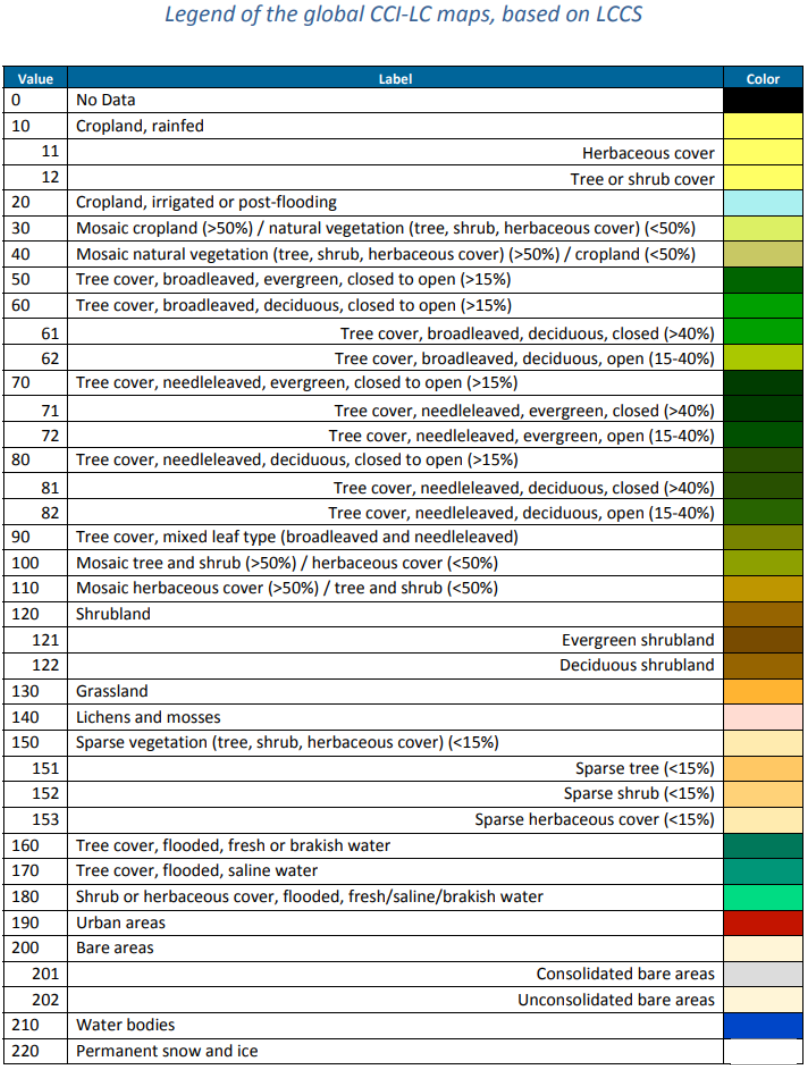